In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Data

In [102]:
data_train = pd.read_csv('../data/landmark_train.csv', header = None)
data_train.rename(columns={0: 'class'}, inplace=True)

data_val = pd.read_csv('../data/landmark_val.csv', header = None)
data_val.rename(columns={0: 'class'}, inplace=True)

data_test = pd.read_csv('../data/landmark_test.csv', header = None)
data_test.rename(columns={0: 'class'}, inplace=True)

In [103]:
data_train.head()

,class,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,1,0.737817,0.952539,-3.422762e-07,0.679783,0.910816,-0.040841,0.638355,0.798009,-0.067538,...,-0.079880,0.812031,0.786412,-0.110996,0.777773,0.853772,-0.109390,0.756940,0.840830,-0.103323
1,1,0.737788,0.949083,-3.280368e-07,0.679917,0.908141,-0.040232,0.638414,0.794934,-0.066173,...,-0.077981,0.809808,0.787309,-0.108219,0.775743,0.852140,-0.106052,0.755859,0.839046,-0.099421
2,1,0.740318,0.952811,-3.727930e-07,0.680487,0.912496,-0.040986,0.638046,0.801638,-0.068100,...,-0.079770,0.816616,0.784904,-0.111412,0.782650,0.853981,-0.109616,0.760015,0.842810,-0.103190
3,1,0.736159,0.958327,-3.369044e-07,0.677534,0.917838,-0.043093,0.635010,0.810609,-0.072415,...,-0.083434,0.813695,0.791525,-0.114416,0.779570,0.860431,-0.111203,0.757949,0.846861,-0.103791
4,1,0.736295,0.961405,-2.995568e-07,0.677813,0.919901,-0.039999,0.633051,0.815260,-0.067304,...,-0.081325,0.801587,0.814893,-0.110820,0.769165,0.876808,-0.107950,0.753947,0.866378,-0.100151


In [104]:
data_train['class'].value_counts()
# Balanced dataset

class
4    270
3    265
1    238
0    227
2    224
Name: count, dtype: int64

In [105]:
# Convert dataframe to array
X_train = data_train.iloc[:, 1:].values
y_train = data_train.iloc[:, 0].values

X_val = data_val.iloc[:, 1:].values
y_val = data_val.iloc[:, 0].values

X_test = data_test.iloc[:, 1:].values
y_test = data_test.iloc[:, 0].values

In [106]:
X_train.shape, y_train.shape

((1224, 63), (1224,))

# Normalize data

In [107]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((1224, 63), (422, 63), (453, 63), (1224,), (422,), (453,))

In [108]:
# Convert nparray to tensor because torch only accepts tensor and we need to use neural network
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Build DataLoader

In [109]:
batch_size = 64

In [128]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
        
training_data = CustomDataset(X_train, y_train)
test_data = CustomDataset(X_test, y_test)
val_data = CustomDataset(X_val, y_val)

train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Build MLP Model - ThuyDuc Ver

In [162]:
from typing import Literal, Optional
import math
import random
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_layer, output_size, hidden_size_changer : Literal['linear', 'fibonacci', 'logarit', 'random', 'increase_decrease'] | None = None, 
                 level_of_change : float = 1):
        super().__init__()
        
        # Set up layers
        layers = [
            nn.Linear(input_size, hidden_size),
            nn.Tanh()
        ]
        if hidden_size_changer == 'linear': # tăng tuyến tính
            hidden_size_new = int(hidden_size * level_of_change)
            for i in range(1, hidden_layer):

                layers.append(nn.Linear(hidden_size, hidden_size_new))
                layers.append(nn.Tanh()) 

                hidden_size = hidden_size_new
                hidden_size_new = int(hidden_size_new * level_of_change)

            layers.append(nn.Linear(hidden_size, output_size))

            self.classifier = nn.Sequential(*layers)

        elif hidden_size_changer == 'fibonacci':
            fibo_sizes = [hidden_size, hidden_size]  # Bắt đầu với hai giá trị đầu giống nhau

            # Tạo dãy Fibonacci cho số lượng hidden layers
            for _ in range(2, hidden_layer + 1):  # +1 vì còn output layer sau cùng
                fibo_sizes.append(fibo_sizes[-1] + fibo_sizes[-2])

            # Tạo các hidden layer với số node theo dãy Fibonacci
            for i in range(hidden_layer):
                layers.append(nn.Linear(fibo_sizes[i], fibo_sizes[i + 1]))
                layers.append(nn.Tanh())  # hoặc nn.ReLU() tùy theo bạn muốn

            # Layer cuối cùng nối đến output
            layers.append(nn.Linear(fibo_sizes[-1], output_size))

            self.classifier = nn.Sequential(*layers)

        elif hidden_size_changer == 'logarit':
            for i in range(1, hidden_layer + 1):
                hidden_size_new = int(hidden_size * level_of_change * math.log(i + 1))  # i + 1 để tránh log(0)
                
                layers.append(nn.Linear(hidden_size, hidden_size_new))
                layers.append(nn.Tanh())  # hoặc dùng ReLU nếu muốn

                hidden_size = hidden_size_new

            layers.append(nn.Linear(hidden_size, output_size))

            self.classifier = nn.Sequential(*layers)

        
        elif hidden_size_changer == 'random':
            for i in range(1, hidden_layer + 1):
                # Tăng ngẫu nhiên: từ hidden_size đến hidden_size * level_of_change
                min_size = min(hidden_size + 1, int(hidden_size * level_of_change))
                max_size = max(hidden_size + 1, int(hidden_size * level_of_change))

                hidden_size_new = random.randint(min_size, max_size)

                layers.append(nn.Linear(hidden_size, hidden_size_new))
                layers.append(nn.Tanh())  # hoặc dùng ReLU nếu muốn

                hidden_size = hidden_size_new

            layers.append(nn.Linear(hidden_size, output_size))

            self.classifier = nn.Sequential(*layers)
        
        elif hidden_size_changer == 'increase_decrease':
            mid = hidden_layer // 2  # vị trí chuyển từ tăng sang giảm

            hidden_sizes = [hidden_size]

            # Giai đoạn tăng
            for i in range(1, mid + 1):
                next_size = int(hidden_sizes[-1] * level_of_change)
                hidden_sizes.append(next_size)

            # Giai đoạn giảm
            for i in range(mid + 1, hidden_layer + 1):
                next_size = max(1, int(hidden_sizes[-1] / level_of_change))  # tránh về 0
                hidden_sizes.append(next_size)

            # Tạo các hidden layers
            for i in range(hidden_layer):
                layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
                layers.append(nn.Tanh())  # hoặc ReLU

            # Output layer
            layers.append(nn.Linear(hidden_sizes[-1], output_size))

            self.classifier = nn.Sequential(*layers)

        else:
            for _ in range(hidden_layer - 1):
                layers.append(nn.Linear(hidden_size, hidden_size))
                layers.append(nn.Tanh())
            
            layers.append(nn.Linear(hidden_size, output_size))

            self.classifier = nn.Sequential(*layers)
        
        # Initialize weights
        for layer in self.classifier:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
    
    def forward(self, X):
        output = self.classifier(X)
        return output

# Training Session

In [173]:
lr = 0.1
epochs = 200
input_size = X_train.shape[1]
hidden_size_changer = 'logarit'
level_of_change = 2
hidden_size = 10
hidden_layer = 5
output_size = len(torch.unique(y_train))

In [167]:
train_lossess = []
val_lossess = []
f1_train = []
f1_val = []

In [174]:
model = NeuralNetwork(input_size, hidden_size, hidden_layer, output_size, hidden_size_changer = hidden_size_changer, level_of_change = level_of_change)

optimizer = optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()
model

NeuralNetwork(
  (classifier): Sequential(
    (0): Linear(in_features=63, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=13, bias=True)
    (3): Tanh()
    (4): Linear(in_features=13, out_features=28, bias=True)
    (5): Tanh()
    (6): Linear(in_features=28, out_features=77, bias=True)
    (7): Tanh()
    (8): Linear(in_features=77, out_features=247, bias=True)
    (9): Tanh()
    (10): Linear(in_features=247, out_features=885, bias=True)
    (11): Tanh()
    (12): Linear(in_features=885, out_features=5, bias=True)
  )
)

In [ ]:
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0

    y_train_label_pred = []
    y_train_label_true = []

    y_val_label_pred = []
    y_val_label_true = []

    # training session
    model.train()
    for X_train, y_train in train_loader:
        # reset optimizer to avoid accumalated gradients
        # from previous batch
        optimizer.zero_grad()

        # forward pass
        y_pred = model(X_train)

        # calculate loss
        loss = criterion(y_pred, y_train)
        train_loss += loss.item()

        # concat
        y_train_label_true.extend(y_train.tolist())
        y_train_label_pred.extend(torch.argmax(y_pred, dim=1).tolist())

        # calculate gradients of the loss with respect to the model parameters
        loss.backward()

        # update the model parameters
        optimizer.step()

    train_loss /= len(train_loader)
    train_lossess.append(train_loss)

    f1_score_train = f1_score(y_train_label_true, y_train_label_pred, average='macro')
    f1_train.append(f1_score_train)
    
    # validation session
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            # forward pass
            y_pred = model(X_val)

            # calculate loss
            loss = criterion(y_pred, y_val)
            val_loss += loss.item()

            # concat
            y_val_label_true.extend(y_val.tolist())
            y_val_label_pred.extend(torch.argmax(y_pred, dim=1).tolist())

        val_loss /= len(val_loader)
        val_lossess.append(val_loss)

        f1_score_val = f1_score(y_val_label_true, y_val_label_pred, average='macro')
        f1_val.append(f1_score_val)
    


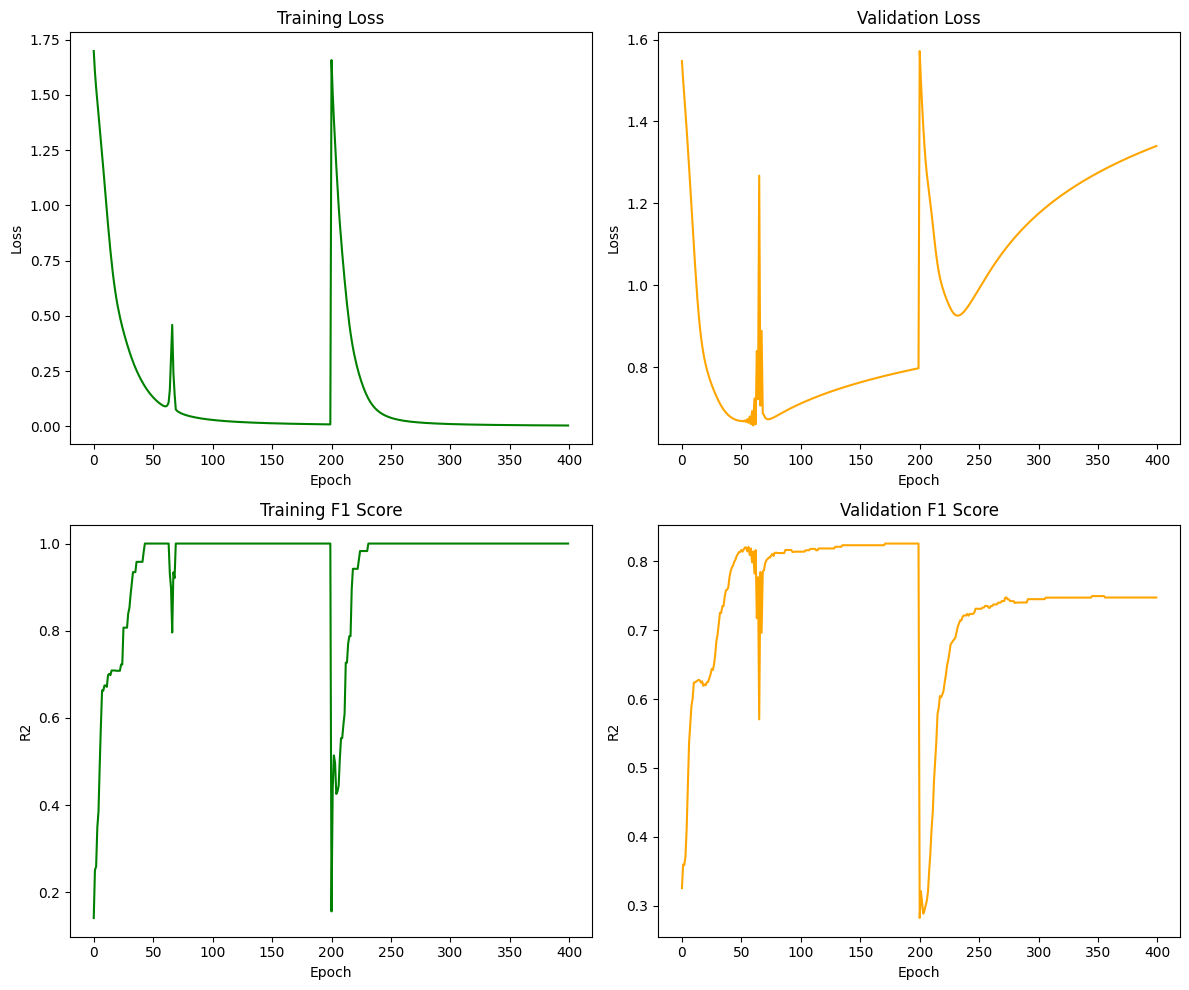

In [176]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_lossess, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_lossess, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(f1_train, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='R2')
ax[1, 0].set_title('Training F1 Score')

ax[1, 1].plot(f1_val, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='R2')
ax[1, 1].set_title('Validation F1 Score')
plt.tight_layout()

plt.show()

In [122]:
model.state_dict()

OrderedDict([('classifier.0.weight',
              tensor([[ 0.0882,  0.1145,  0.0509,  0.1606, -0.0620, -0.0872,  0.1024,  0.0301,
                        0.0353,  0.2585, -0.2882, -0.2562,  0.2067, -0.1866, -0.0777,  0.2697,
                       -0.1397,  0.2265,  0.0011, -0.0431, -0.0098, -0.1746,  0.3379,  0.2474,
                        0.1060,  0.0557, -0.2349,  0.0955,  0.1090, -0.3063, -0.1376,  0.0539,
                        0.0824,  0.2487,  0.2323,  0.0637, -0.1938,  0.1411, -0.1838, -0.2908,
                       -0.1196,  0.2049, -0.0204,  0.3174,  0.0662,  0.2574,  0.0019, -0.2969,
                        0.1363, -0.1202,  0.1498, -0.0576,  0.2841, -0.1725,  0.0518, -0.0531,
                        0.0527,  0.0341, -0.1608,  0.2442, -0.0726,  0.2254, -0.1351],
                      [ 0.2196,  0.3891, -0.4036,  0.2450,  0.0335,  0.1250, -0.1821, -0.1425,
                       -0.0557, -0.0573, -0.0678,  0.1274, -0.0865, -0.1788, -0.0368, -0.2910,
                     